In [800]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

In [801]:
# read into dataframe
url = '/content/chocolate.csv'
df = pd.read_csv(url)

In [802]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        2224 non-null   int64  
 1   ref                               2224 non-null   int64  
 2   company                           2224 non-null   object 
 3   company_location                  2224 non-null   object 
 4   review_date                       2224 non-null   int64  
 5   country_of_bean_origin            2224 non-null   object 
 6   specific_bean_origin_or_bar_name  2224 non-null   object 
 7   cocoa_percent                     2224 non-null   float64
 8   rating                            2224 non-null   float64
 9   counts_of_ingredients             2224 non-null   int64  
 10  beans                             2224 non-null   object 
 11  cocoa_butter                      2224 non-null   object 
 12  vanill

In [803]:
df.head()

,Unnamed: 0,ref,company,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,rating,counts_of_ingredients,...,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste
0,0,2454,5150,U.S.A,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3.75,3,...,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,blackberry,full body,NaN
1,1,2458,5150,U.S.A,2019,Dominican republic,"Zorzal, batch 1",76.0,3.50,3,...,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,vegetal,savory,NaN
2,2,2454,5150,U.S.A,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.25,3,...,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,rich cocoa,fatty,bready,NaN
3,3,797,A. Morin,France,2012,Peru,Peru,63.0,3.75,4,...,have_cocoa_butter,have_not_vanila,have_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,fruity,melon,roasty,NaN
4,4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,3.50,4,...,have_cocoa_butter,have_not_vanila,have_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,vegetal,nutty,NaN,NaN


In [804]:
# Since too many varieties in first&second tastes, keep the 5 most frequent tastes and assign the rest with Other
top_5_first = df['first_taste'].value_counts().nlargest(5).index
df['first_taste'] = df['first_taste'].apply(lambda x: x if x in top_5_first else 'Other')

top_5_second = df['first_taste'].value_counts().nlargest(5).index
df['second_taste'] = df['second_taste'].apply(lambda x: x if x in top_5_second else 'Other')

In [805]:
# drop 'beans' since all have beans &  drop columns too detailed to be generalized/ unrelated to rating
df = df.drop(columns = ['company_location','specific_bean_origin_or_bar_name','third_taste','fourth_taste', 'beans','company'], axis = 1)

In [806]:
# Create map to map country_of_bean_origin to bigger bean_region
region_map = {
    # South America (SA)
    'Brazil': 'SA', 'Peru': 'SA', 'Ecuador': 'SA','Colombia': 'SA', 'Venezuela': 'SA', 'Bolivia': 'SA','Suriname': 'SA',

    # Central America & Caribbean (CA&C)
    'Dominican republic': 'CA&C', 'Grenada': 'CA&C', 'Jamaica': 'CA&C','Trinidad': 'CA&C', 'Cuba': 'CA&C', 'Honduras': 'CA&C','Guatemala': 'CA&C', 'Costa rica': 'CA&C', 'Panama': 'CA&C',
    'Haiti': 'CA&C', 'Belize': 'CA&C', 'St. lucia': 'CA&C','St.vincent–grenadines': 'CA&C', 'El salvador': 'CA&C','Martinique': 'CA&C',

    # Africa (AF)
    'Madagascar': 'AF', 'Ghana': 'AF', 'Ivory coast': 'AF','Nigeria': 'AF', 'Tanzania': 'AF', 'Cameroon': 'AF', 'Uganda': 'AF','Congo': 'AF', 'Dr congo': 'AF', 'Togo': 'AF', 'Sao tome': 'AF',
    'Sao tome & principe': 'AF', 'Principe': 'AF', 'Liberia': 'AF','Sierra leone': 'AF',

    # Asia (AS)
    'India': 'AS', 'Philippines': 'AS', 'Vietnam': 'AS', 'Indonesia': 'AS','Sri lanka': 'AS', 'Thailand': 'AS', 'Malaysia': 'AS','Sumatra': 'AS', 'Taiwan': 'AS','Burma': 'AS',

    # Oceania (OC)
    'Fiji': 'OC', 'Vanuatu': 'OC', 'Papua new guinea': 'OC','Solomon islands': 'OC',

    # North America
    'U.s.a.': 'North America',

    # Unknown or Mixed
    'Blend': 'Mixed/Other'
}

In [807]:
# Apply region_map
df['bean_region'] = df['country_of_bean_origin'].map(region_map)

# Drop country_of_bean_origin
df = df.drop(columns = 'country_of_bean_origin', axis = 1)

In [808]:
# Majortiy rows have_not_salt, have_sugar, have_not_sweetener_without_sugar.
# Only keep these rows and drop corresponding columns to reduce unnecessary criteria
df = df[
    (df['salt'] == 'have_not_salt') &
    (df['sugar'] == 'have_sugar') &
    (df['sweetener_without_sugar'] == 'have_not_sweetener_without_sugar')
]

df = df.drop(columns = ['salt', 'sugar','sweetener_without_sugar'], axis = 1)

In [809]:
# Drop null/0 and non-related columns
df = df.dropna()
df = df.drop(columns = ['Unnamed: 0','ref'], axis = 1)

In [810]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1976 entries, 0 to 2223
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            1976 non-null   int64  
 1   cocoa_percent          1976 non-null   float64
 2   rating                 1976 non-null   float64
 3   counts_of_ingredients  1976 non-null   int64  
 4   cocoa_butter           1976 non-null   object 
 5   vanilla                1976 non-null   object 
 6   lecithin               1976 non-null   object 
 7   first_taste            1976 non-null   object 
 8   second_taste           1976 non-null   object 
 9   bean_region            1976 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 169.8+ KB


In [811]:
df.head()

,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,first_taste,second_taste,bean_region
0,2019,76.0,3.75,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,Other,Other,AF
1,2019,76.0,3.50,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,Other,Other,CA&C
2,2019,76.0,3.25,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,Other,Other,AF
3,2012,63.0,3.75,4,have_cocoa_butter,have_not_vanila,have_lecithin,Other,Other,SA
4,2012,70.0,3.50,4,have_cocoa_butter,have_not_vanila,have_lecithin,Other,nutty,SA


**Exploratory Data Analysis**

Descriptive Statistics

In [812]:
# Average chocolate rating
float(df['rating'].mean())

3.2105769230769234

In [813]:
# Minimum chocolate rating
float(df['rating'].min())

1.0

In [814]:
# Maximum chocolate rating
float(df['rating'].max())

4.0

Text(0.5, 1.0, 'Boxplot of Chocolate Ratings')

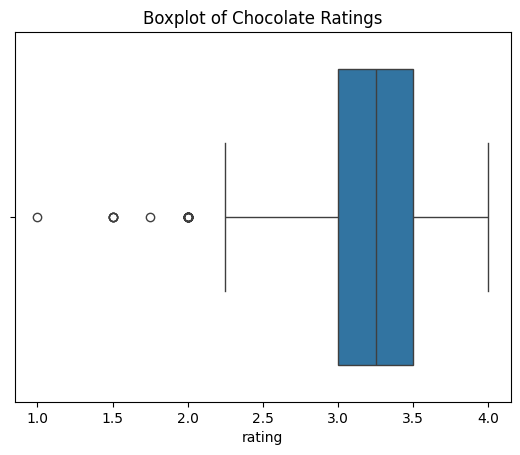

In [815]:
# Box plot of ratings
sns.boxplot(data = df, x = 'rating')
plt.title('Boxplot of Chocolate Ratings')

Text(0.5, 1.0, 'Distribution of Chocolate Ratings')

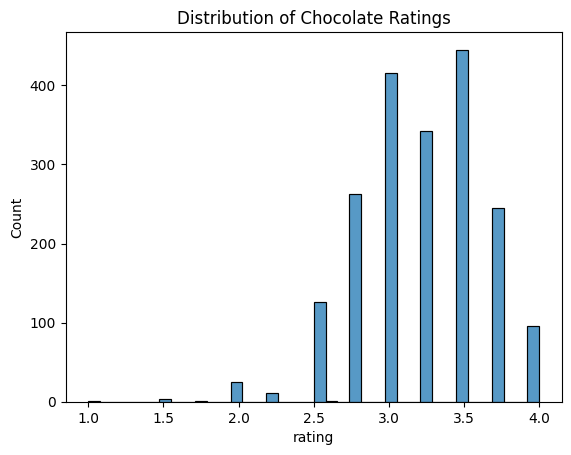

In [816]:
# Histogram of ratings
sns.histplot(data = df, x = 'rating')
plt.title('Distribution of Chocolate Ratings')

Visualization

In [817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1976 entries, 0 to 2223
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            1976 non-null   int64  
 1   cocoa_percent          1976 non-null   float64
 2   rating                 1976 non-null   float64
 3   counts_of_ingredients  1976 non-null   int64  
 4   cocoa_butter           1976 non-null   object 
 5   vanilla                1976 non-null   object 
 6   lecithin               1976 non-null   object 
 7   first_taste            1976 non-null   object 
 8   second_taste           1976 non-null   object 
 9   bean_region            1976 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 169.8+ KB


<ipython-input-818-2cf2191e710b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'review_date', y = 'rating',palette='coolwarm')


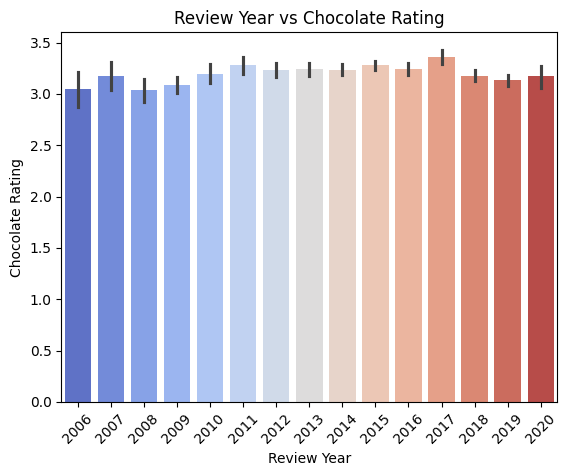

In [818]:
# Review Year vs. Chocolate Rating
sns.barplot(data = df, x = 'review_date', y = 'rating',palette='coolwarm')
plt.title('Review Year vs Chocolate Rating')
plt.xlabel('Review Year')
plt.ylabel('Chocolate Rating')
plt.xticks(rotation=45);
# no significant differnece/ patterns between years

<ipython-input-819-fa25c4cad749>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='cocoa_bin', y='rating', errorbar='sd',palette='coolwarm' )


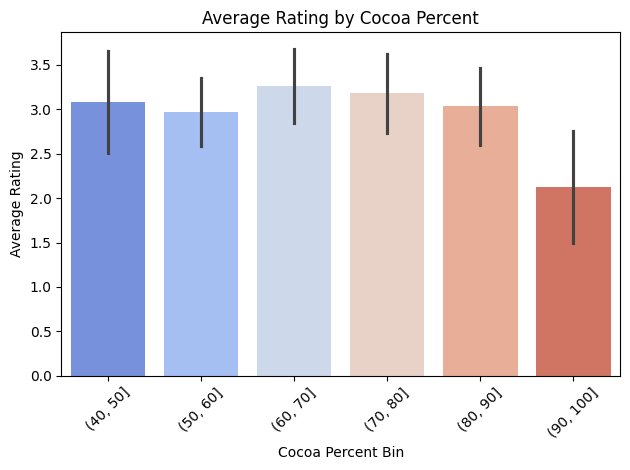

In [819]:
df['cocoa_bin'] = pd.cut(df['cocoa_percent'], bins=range(40, int(df['cocoa_percent'].max()) + 10, 10))

sns.barplot(data=df, x='cocoa_bin', y='rating', errorbar='sd',palette='coolwarm' )
plt.xticks(rotation=45)
plt.title('Average Rating by Cocoa Percent')
plt.xlabel('Cocoa Percent Bin')
plt.ylabel('Average Rating')
plt.tight_layout()

<ipython-input-820-2e8ab127f476>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = df, x='cocoa_butter', y='rating',palette='GnBu', ax=ax[0])
<ipython-input-820-2e8ab127f476>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = df, x='vanilla', y='rating',palette='BuPu', ax=ax[1])
<ipython-input-820-2e8ab127f476>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = df, x='lecithin', y='rating',palette='PuRd', ax=ax[2])


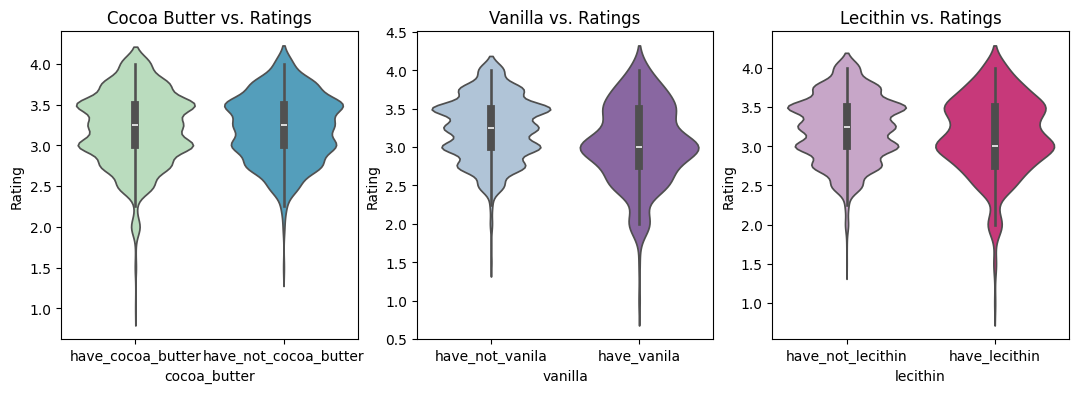

In [820]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# First plot: Cocoa butter vs. Ratings
sns.violinplot(data = df, x='cocoa_butter', y='rating',palette='GnBu', ax=ax[0])

ax[0].set_title('Cocoa Butter vs. Ratings')
ax[0].set_ylabel('Rating')

# Second plot: Vanilla vs Ratings
sns.violinplot(data = df, x='vanilla', y='rating',palette='BuPu', ax=ax[1])

ax[1].set_title('Vanilla vs. Ratings')
ax[1].set_ylabel('Rating')

# Third plot: Lecithin vs. Ratings
sns.violinplot(data = df, x='lecithin', y='rating',palette='PuRd', ax=ax[2])

ax[2].set_title('Lecithin vs. Ratings')
ax[2].set_ylabel('Rating');

<ipython-input-821-cebd50ed2418>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='bean_region', order=df['bean_region'].value_counts().index, palette='Set2')


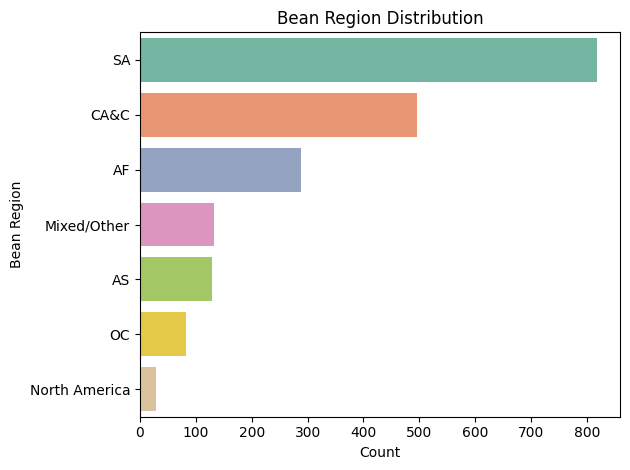

In [821]:
# Bean Region Distribution
sns.countplot(data=df, y='bean_region', order=df['bean_region'].value_counts().index, palette='Set2')
plt.title('Bean Region Distribution')
plt.xlabel('Count')
plt.ylabel('Bean Region')
plt.tight_layout();

<Figure size 100x50 with 0 Axes>

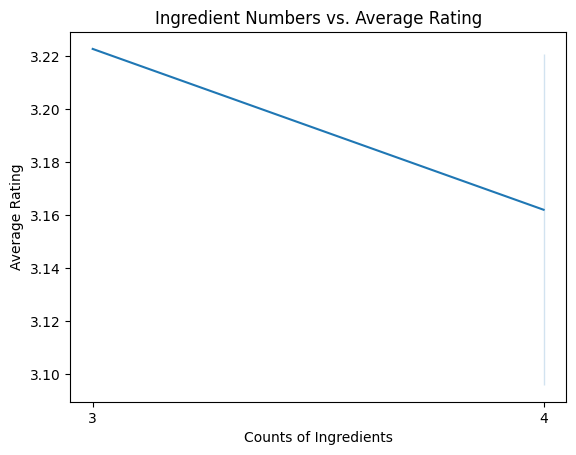

<Figure size 100x50 with 0 Axes>

In [822]:
# Ingredient Numbers vs. Average Rating
df['ave_rating'] = df.groupby('counts_of_ingredients')['rating'].mean()
sns.lineplot(data = df, x = 'counts_of_ingredients', y = 'ave_rating')
plt.xticks([3, 4])

plt.xlabel('Counts of Ingredients')
plt.ylabel('Average Rating')
plt.title('Ingredient Numbers vs. Average Rating')
plt.figure(figsize=(1, 0.5))

**Modeling**

In [823]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

Baseline Model

In [824]:
y = df['rating']
baseline_preds = np.ones(len(y))*y.mean()
mean_squared_error(y, baseline_preds)

0.18859511250389288

Linear Regression

In [825]:
# Create X & y, split into training and testing data

# since 'counts_of_ingredients' is highly correlated with specific ingredients columns(cocoa_butter, vanilla, ...), we exclude the column
# based on EDA, the review date has no obvious relation with chocolate rating (and it should not be), so we exclude the column

X = df[['cocoa_percent','cocoa_butter','vanilla','lecithin','first_taste','second_taste','bean_region']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [826]:
# Encode categorical column
cat_col = ['first_taste', 'second_taste','bean_region', 'cocoa_butter','vanilla','lecithin']
num_col = ['cocoa_percent']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = 'passthrough')

In [827]:
# Create pipeline for multiple regression model
lr_pipe = Pipeline([('encode', transformer), ('model', LinearRegression())])

In [828]:
# Fit pipeline
lr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['first_taste',
                                                   'second_taste',
                                                   'bean_region',
                                                   'cocoa_butter', 'vanilla',
                                                   'lecithin'])])),
                ('model', LinearRegression())])

In [829]:
# Find coefficients
lr = lr_pipe.named_steps['model']
coefficients = lr.coef_
names = transformer.get_feature_names_out()
pd.DataFrame(coefficients, names)

,0
onehotencoder__first_taste_creamy,0.322068
onehotencoder__first_taste_fatty,-0.172811
onehotencoder__first_taste_intense,0.065608
onehotencoder__first_taste_nutty,0.124832
onehotencoder__first_taste_sandy,-0.124428
onehotencoder__second_taste_creamy,0.122838
onehotencoder__second_taste_intense,0.056634
onehotencoder__second_taste_nutty,0.139943
onehotencoder__second_taste_sandy,0.066322
onehotencoder__bean_region_AS,-0.066566


In [830]:
# Find y intercept
lr.intercept_

np.float64(3.8372174740674505)

In [831]:
# Calculate mse for training data
y_train_preds = lr_pipe.predict(X_train)
mean_squared_error(y_train, y_train_preds)

0.17297778352124954

In [832]:
# Calculate mse for testing data
y_test_preds = lr_pipe.predict(X_test)
mean_squared_error(y_test, y_test_preds)

0.17061069883708987

In [833]:
# Determine feature importance
r = permutation_importance(lr_pipe, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
cocoa_percent,0.007997
cocoa_butter,0.006932
vanilla,0.061706
lecithin,0.009440
first_taste,0.060598
second_taste,0.001766
bean_region,-0.000868


KNN


In [834]:
#Create X & y, split into training and testing data
X = df[['cocoa_percent','cocoa_butter','vanilla','lecithin','first_taste','second_taste','bean_region']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [835]:
# Encode categorical column
cat_col = ['first_taste', 'second_taste','bean_region', 'cocoa_butter','vanilla','lecithin']
num_col = ['cocoa_percent']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = StandardScaler())

In [836]:
# Create pipeline for knn regression model
knn_pipe = Pipeline([('encode', transformer), ('model', KNeighborsRegressor())])

In [837]:
# Define grid of hyperparameters for number of neighbors
param_grid = {'model__n_neighbors': np.arange(1, 30, 2)}

In [838]:
# Perform grid-search with cross validation
grid_search = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['first_taste',
                                                                          'second_taste',
                                                                          'bean_region',
                                                                          'cocoa_butter',
                                                                          'vanilla',
                                                                          'lecithin'])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='neg_mean_squared_error')

In [839]:
# Determine best parameter
grid_search.best_params_

{'model__n_neighbors': np.int64(21)}

In [840]:
# Use 21 neighbors in model
knn = grid_search.best_estimator_

In [841]:
# Calculate mse for training data
y_train_preds = knn.predict(X_train)
mean_squared_error(y_train, y_train_preds)

0.16833181259970845

In [842]:
# Calculate mse for testing data
y_test_preds = knn.predict(X_test)
mean_squared_error(y_test, y_test_preds)

0.17443178732988418

In [843]:
# Determine feature importance
r = permutation_importance(knn, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
cocoa_percent,0.047167
cocoa_butter,0.017843
vanilla,0.027017
lecithin,0.005597
first_taste,0.030237
second_taste,-0.002340
bean_region,-0.002969


Decision Tree

In [844]:
#Create X & y, split into training and testing data
X = df[['cocoa_percent','cocoa_butter','vanilla','lecithin','first_taste','second_taste','bean_region']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [845]:
# Encode categorical column
cat_col = ['first_taste', 'second_taste','bean_region', 'cocoa_butter','vanilla','lecithin']
num_col = ['cocoa_percent']
encoder = make_column_transformer((OneHotEncoder(sparse_output = False),cat_col), verbose_feature_names_out = False, remainder = 'passthrough')

In [846]:
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

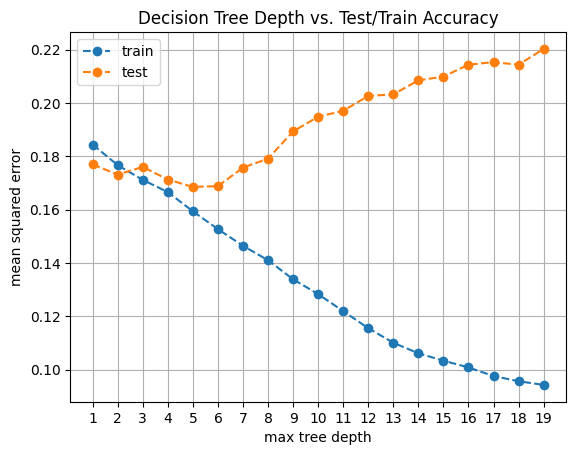

In [847]:
# Find the optimal max depth while avoiding overfitting by plotting the test accuracies & finding the minimum one
train_scores = []
test_scores = []
for d in range(1, 20):
    dtree = DecisionTreeRegressor(max_depth = d).fit(X_train_encoded, y_train)
    y_train_preds = dtree.predict(X_train_encoded)
    y_test_preds = dtree.predict(X_test_encoded)
    train_scores.append(mean_squared_error(y_train, y_train_preds))
    test_scores.append(mean_squared_error(y_test, y_test_preds))

plt.plot(range(1, 20), train_scores, '--o', label = 'train')
plt.plot(range(1, 20), test_scores, '--o', label = 'test')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('max tree depth')
plt.ylabel('mean squared error')
plt.title('Decision Tree Depth vs. Test/Train Accuracy');

In [848]:
# Fit a decision tree model with a max depth = 5 (lowest mse test score on graph)
dtree = DecisionTreeRegressor(max_depth = 5).fit(X_train_encoded, y_train)

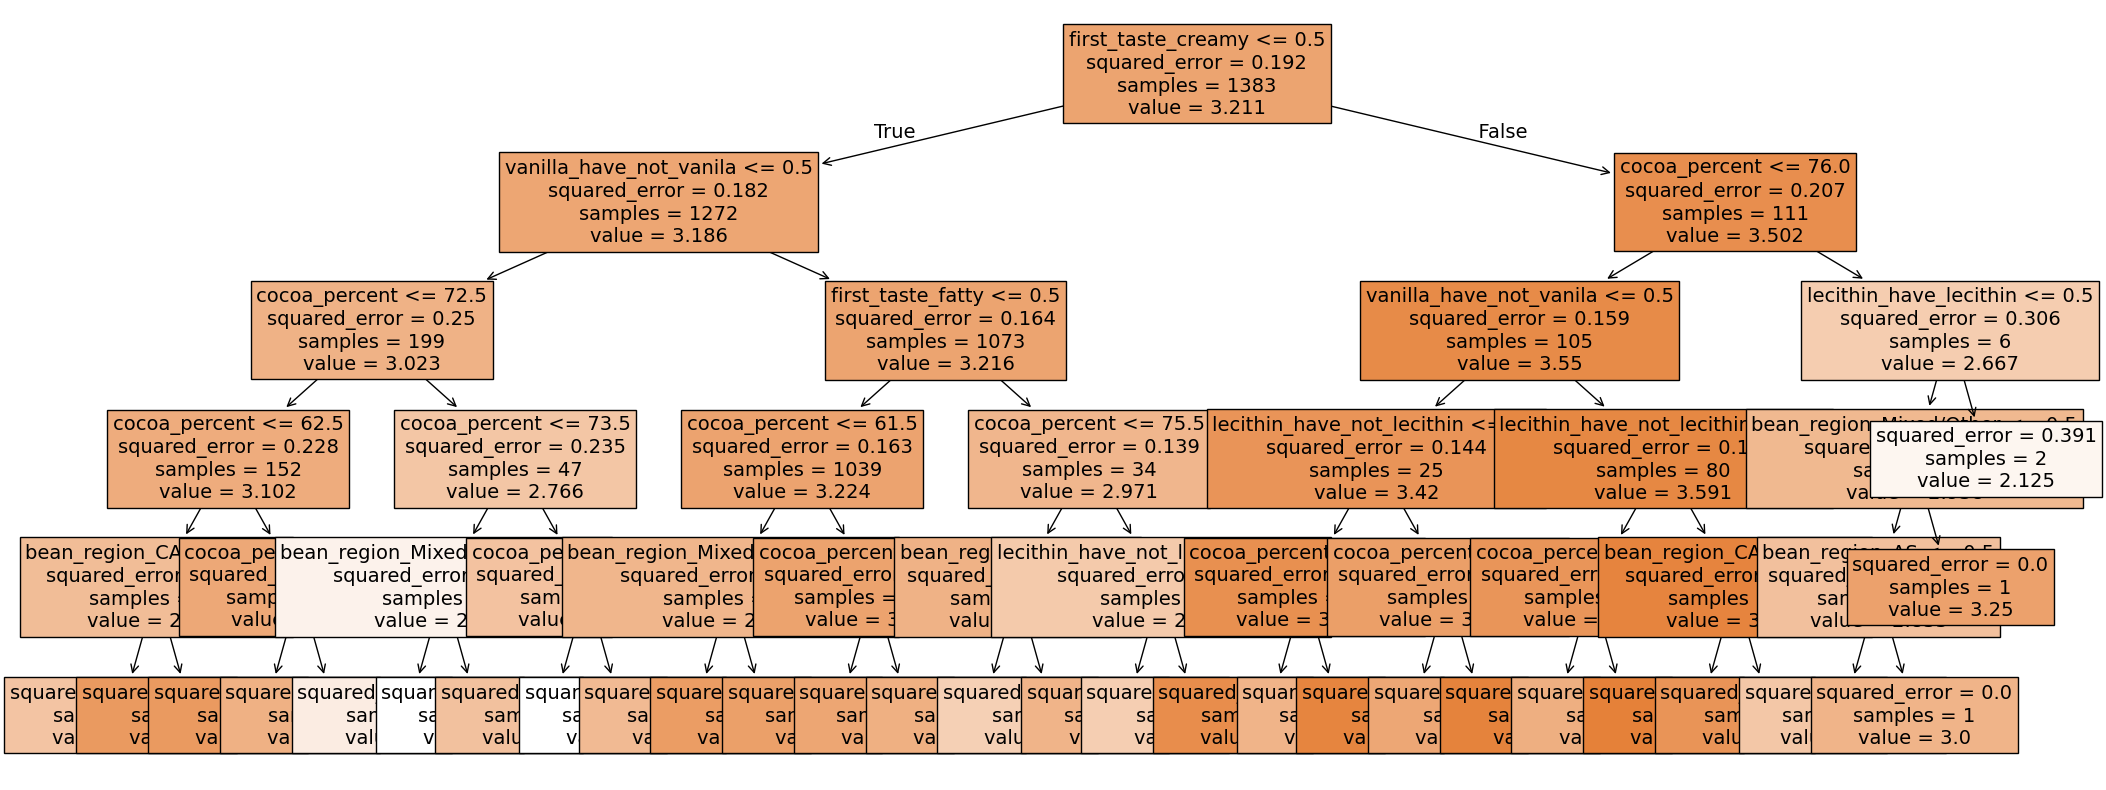

In [849]:
# Plot the tree
plt.figure(figsize=(25, 10))
plot_tree(dtree, filled=True, feature_names=encoder.get_feature_names_out().tolist(), fontsize=14);

In [850]:
# Calculate mse for training data
y_train_preds = dtree.predict(X_train_encoded)
mean_squared_error(y_train, y_train_preds)

0.15935208726758573

In [851]:
# Calculate mse for testing data
y_test_preds = dtree.predict(X_test_encoded)
mean_squared_error(y_test, y_test_preds)

0.16848185585317949

Random Forest

In [868]:
# Create X & y, split into training and testing data
X = df[['cocoa_percent','cocoa_butter','vanilla','lecithin','first_taste','second_taste','bean_region']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [869]:
# Encode categorical column
cat_col = ['first_taste', 'second_taste','bean_region', 'cocoa_butter','vanilla','lecithin']
num_col = ['cocoa_percent']
transformer = make_column_transformer((OneHotEncoder(drop = 'first', sparse_output = False), cat_col), remainder = 'passthrough')

In [870]:
# Create pipeline for multiple regression model
forest_pipe = Pipeline([('encode', transformer), ('model', RandomForestRegressor())])

In [871]:
# Define grid of hyperparameters for number of estimators and max depth
param_grid = {'model__n_estimators': [50, 100, 150, 200, 250],'model__max_depth': [2,3,4,5,6,8,10]}

In [872]:
# Perform grid-search w/ cross validation
grid_search = GridSearchCV(forest_pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['first_taste',
                                                                          'second_taste',
                                                                          'bean_region',
                                                                          'cocoa_butter',
                                                                          'vanilla',
                                                                          'lecithin'])])),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6, 8, 10],
                         'model__n_estimators': [50, 100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [874]:
# Determine best parameters
grid_search.best_params_

{'model__max_depth': 6, 'model__n_estimators': 150}

In [875]:
# Apply the best estimator
forest = grid_search.best_estimator_

In [876]:
# Calculate mse for training data
y_train_preds = forest.predict(X_train)
mean_squared_error(y_train, y_train_preds)

0.14856856114804856

In [877]:
# Calculate mse for testing data
y_test_preds = forest.predict(X_test)
mean_squared_error(y_test, y_test_preds)

0.1674196864108165

In [861]:
# Determine feature importance
r = permutation_importance(forest, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
cocoa_percent,0.096145
cocoa_butter,0.006526
vanilla,0.063749
lecithin,0.013845
first_taste,0.062283
second_taste,0.002307
bean_region,-0.007884


Neural Network (Not Chosen)

In [862]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [863]:
# Create X & y, split into training and testing data
X = df[['cocoa_percent','cocoa_butter','vanilla','lecithin','first_taste','second_taste','bean_region']]
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)

In [864]:
cat_col = ['first_taste', 'second_taste','bean_region', 'cocoa_butter','vanilla','lecithin']
num_col = ['cocoa_percent']

preprocessor = make_column_transformer(
    (StandardScaler(), num_col),
    (OneHotEncoder(handle_unknown='ignore'), cat_col)
)

In [865]:
# Apply fit/transform
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [881]:
# Convert to float32 tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [878]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [879]:
# Neural network model
nnmodel = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(nnmodel.parameters(), lr=0.001, momentum=0.9)

In [880]:
n_epochs = 300

for epoch in range(n_epochs):
    nnmodel.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        preds = nnmodel(X_batch)
        loss = loss_fn(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print every 10 epochs
    if epoch % 10 == 0:
        nnmodel.eval()
        with torch.no_grad():
            y_test_preds = nnmodel(X_test_tensor)
            test_loss = mean_squared_error(y_test_tensor.numpy(), y_test_preds.numpy())

        print(f"Epoch {epoch:<4} Train Loss: {loss.item():.4f}, Test MSE: {test_loss:.4f}")

Epoch 0    Train Loss: 0.5312, Test MSE: 0.3296
Epoch 10   Train Loss: 0.0591, Test MSE: 0.1743
Epoch 20   Train Loss: 0.2539, Test MSE: 0.1728
Epoch 30   Train Loss: 0.1943, Test MSE: 0.1714
Epoch 40   Train Loss: 0.1375, Test MSE: 0.1710
Epoch 50   Train Loss: 0.1284, Test MSE: 0.1713
Epoch 60   Train Loss: 0.2767, Test MSE: 0.1716
Epoch 70   Train Loss: 0.2104, Test MSE: 0.1718
Epoch 80   Train Loss: 0.0723, Test MSE: 0.1717
Epoch 90   Train Loss: 0.1375, Test MSE: 0.1718
Epoch 100  Train Loss: 0.2314, Test MSE: 0.1717
Epoch 110  Train Loss: 0.2242, Test MSE: 0.1718
Epoch 120  Train Loss: 0.2455, Test MSE: 0.1736
Epoch 130  Train Loss: 0.1122, Test MSE: 0.1724
Epoch 140  Train Loss: 0.0816, Test MSE: 0.1739
Epoch 150  Train Loss: 0.1284, Test MSE: 0.1719
Epoch 160  Train Loss: 0.2066, Test MSE: 0.1741
Epoch 170  Train Loss: 0.1354, Test MSE: 0.1720
Epoch 180  Train Loss: 0.2386, Test MSE: 0.1723
Epoch 190  Train Loss: 0.1899, Test MSE: 0.1736
Epoch 200  Train Loss: 0.2097, Test MSE: